<a href="https://colab.research.google.com/github/KarelZe/thesis/blob/dataset/notebooks/3.0-mb-data_preprocessing_explanatory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gcsfs==2022.10.0
#!pip install wandb==0.13.4
!pip install scikit-learn==1.1.3
# !pip install SciencePlots==1.0.9
!pip install seaborn==0.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==1.1.3 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0b1, 0.15.0b2, 0.15.0, 0.15.1, 0.15.2, 0.16b1, 0.16.0, 0.16.1, 0.17b1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19b2, 0.19.0, 0.19.1, 0.19.2, 0.20rc1, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21rc2, 0.21.0, 0.21.1, 0.21.2, 0.21.3, 0.22rc2.post1, 0.22rc3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0rc1, 0.23.0, 0.23.1, 0.23.2, 0.24.dev0, 0.24.0rc1, 0.24.0, 0.24.1, 0.24.2, 1.0rc1, 1.0rc2, 1.0, 1.0.1, 1.0.2)
ERROR: No matching distribution found for scikit-learn==1.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 288 kB 3.9 MB/s 
  Attempting uni

In [2]:
import os
import random

import gcsfs
import google.auth
from google.colab import auth

import numpy as np
from numpy.testing import assert_almost_equal
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from pandas._testing.asserters import assert_almost_equal
import pandas as pd

from scipy import stats
from scipy.stats import kurtosis, skew

import seaborn as sns

#import wandb


In [3]:
# set N used in n-largest or smallest
N = 10

In [ ]:
# set style
plt.style.use('seaborn-notebook')

# set ratio of figure
ratio = (16,9)

# plt.style.use(['science','nature', 'no-latex'])

In [ ]:
# connect to weights and biases
# run = wandb.init(project="thesis", job_type="dataset-creation", entity="fbv")

# dataset = wandb.Artifact(name="train_val_test", type="preprocessed_data")


In [4]:
# connect to google cloud storage
auth.authenticate_user()
credentials, _ = google.auth.default()
fs = gcsfs.GCSFileSystem(project="thesis", token=credentials)
fs_prefix = "gs://"


In [5]:
# set fixed seed
def seed_everything(seed):
    """
    Seeds basic parameters for reproducibility of results.
    """
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    # pandas and numpy as discussed here: https://stackoverflow.com/a/52375474/5755604
    np.random.seed(seed)


seed = 42
seed_everything(seed)


In [ ]:
# replace with sampled data set later
files = fs.glob(
    "thesis-bucket-option-trade-classification/data/preprocessed/matched_ise_quotes_min_mem_usage_part_*.parquet",
    recursive=True,
)
files = [fs_prefix + sub for sub in files]

columns = [
    "UNDERLYING_SYMBOL",
    "QUOTE_DATETIME",
    "SEQUENCE_NUMBER",
    "ROOT",
    "EXPIRATION",
    "STRK_PRC",
    "OPTION_TYPE",
    "TRADE_SIZE",
    "TRADE_PRICE",
    "BEST_BID",
    "BEST_ASK",
    "order_id",
    "ask_ex",
    "bid_ex",
    "bid_size_ex",
    "ask_size_ex",
    "price_all_lead",
    "price_all_lag",
    "optionid",
    "day_vol",
    "price_ex_lead",
    "price_ex_lag",
    "buy_sell",
]

dfs = []
for gc_file in files:
    df = pd.read_parquet(gc_file, columns=columns)
    dfs.append(df)
data = pd.concat(dfs)


In [ ]:
data = data.sample(frac=0.2, axis=0, random_state=seed)

## Notes on Data Set 🗃️

**Overview on ticker symbols in 🇺:**
- `others` probably identified by `.`. Index probably identified by `^` e. g., `^NDX` for Nasdq. The `SPY` ETF is however just `SPY`.
- 5th letter has a special meaning as found in [this table](https://en.wikipedia.org/wiki/Ticker_symbol):

| Letter                  | Letter contd.              | Letter contd.                                    |
|--------------------------------|-------------------------------------|------------------------------------------------|
| A – Class "A"                  | K – Nonvoting (common)              | U – Units                                      |
| B – Class "B"                  | L – Miscellaneous                   | V – Pending issue and distribution             |
| C – NextShares                 | M – fourth class – preferred shares | W – Warrants                                   |
| D – New issue or reverse split | N – third class – preferred shares  | X – Mutual fund                                |
| E – Delinquent SEC filings     | O – second class – preferred shares | Y – American depositary receipt (ADR)          |
| F – Foreign                    | P – first class preferred shares    | Z – Miscellaneous situations                   |
| G – first convertible bond     | Q – In bankruptcy                   | Special codes                                  |
| H – second convertible bond    | R – Rights                          | PK – A Pink Sheet, indicating over-the-counter |
| I – third convertible bond     | S – Shares of beneficial interest   | SC – Nasdaq Small Cap                          |
| J – Voting share – special     | T – With warrants or rights         | NM – Nasdaq National Market                    |


**Coverage:**

*	Options on U.S. listed Stock, ETFs, and Indices disseminated over the Options Price Reporting Authority (OPRA) market data feed 
*	Global Trading Hours (GTH) trades are included if between 03:00am-09:15am U.S. Eastern, and for the 16:15pm 17:00pm Curb session.  GTH trades outside of these time ranges will *not* be included. 

Found [here.](https://datashop.cboe.com/documents/Option_Trades_Layout.pdf)

**Exchange Identifier:**

- 5 = Chicago Board Options Exchange (CBOE)
- 6 = International Securities Exchange (ISE)

Found [here.](https://datashop.cboe.com/documents/livevol_exchange_ids.csv)

Adapted from the cboe data shop found at [option trades](https://datashop.cboe.com/documents/Option_Trades_Layout.pdf) and [option quotes](https://datashop.cboe.com/documents/Option_Quotes_Layout.pdf).

|     Column Label                                                          |     Data   Type     |     Description                                                                                                                                                                                                         |
|---------------------------------------------------------------------------|---------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     underlying_symbol                                                     |     string          |     The underlying stock or index.  An index will utilize a caret (^) prefix,   i.e. ^NDX,^SPX,^VIX…etc.  Underlyings   with classes may utilize a dot (.) instead of a slash or space, i.e. BRK.B,   RDS.A, RDS.B.     |
|     quote_datetime                                                        |     datetime        |     The trading date and timestamp of the trade in   U.S. Eastern time. Ex:  yyyymm-dd   hh:mm:ss.000                                                                                                                   |
|     sequence_number                                                       |     integer         |     Trade Sequence Number for the execution reported   by OPRA                                                                                                                                                          |
|     root                                                                  |     string          |     The option trading class symbol.  Non-standard roots may end with a digit                                                                                                                                           |
|     expiration                                                            |     date            |     The explicit expiration date of the option:   yyyy-mm-dd                                                                                                                                                            |
|     strike                                                                |     numeric         |     The exercise/strike price of the option                                                                                                                                                                             |
|     option_type                                                           |     string          |     C for Call options, P for Put options                                                                                                                                                                               |
|     exchange_id                                                           |     integer         |     An identifier for the options exchange the trade   was executed on.  For a mapping, please   see Exchange ID   Mappings                                                                                             |
|     trade_size                                                            |     integer         |     The trade quantity                                                                                                                                                                                                  |
|     trade_price                                                           |     numeric         |     The trade price                                                                                                                                                                                                     |
|     trade_condition_id                                                    |     integer         |     The trade or sale condition of the execution.  For a mapping, please see Trade   Condition ID Mapping                                                                                                               |
|     canceled_trade_condition_id                                           |     integer         |     This field is no longer supported and will default   to 0 (zero).  See IDs 40-43 in the   Trade Condition ID Mapping file above                                                                                     |
|     best_bid                                                              |     numeric         |     The best bid price (NBB) at the time of the trade                                                                                                                                                                   |
|     best_ask                                                              |     numeric         |     The best ask/offer price (NBO) at the time of the   trade                                                                                                                                                           |
|     bid_size              |     integer         |     The largest size from an options exchange   participant on the best bid price (NBB)                                                                                                                                   |
|     bid                   |     numeric         |     The best bid price (NBB) at the interval time   stamp                                                                                                                                                                 |
|     ask_size              |     integer         |     The largest size from an options exchange   participant on the best offer price (NBO)                                                                                                                                 |
|     ask                   |     numeric         |     The best offer price (NBO) at the interval time   stamp                                                                                                                                                               |

## Dtypes, Distributions, Memory 🔭

In [ ]:
data.head()

,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
26219414,NVDA,2013-01-22 13:03:56,21376317,NVDA,2013-02-16,13.000000,P,11,1.04,1.02,...,1.02,51.0,281.0,1.03,1.05,100237952.0,122.0,1.03,1.05,1
35222168,BABA,2015-02-26 14:09:31,140918805,BABA,2015-09-18,70.000000,P,1,1.77,1.77,...,1.77,208.0,71.0,1.80,2.19,106745328.0,1.0,1.83,2.12,-1
46995646,ENDP,2017-01-30 11:18:25,22918467,ENDP,2017-07-21,15.000000,C,20,1.08,0.95,...,0.95,53.0,37.0,1.10,1.10,113865992.0,166.0,1.07,1.15,1
289738,BBBY,2005-06-20 13:41:23,31667806,BHQ,2005-07-16,47.500000,P,1,3.90,3.80,...,3.80,1001.0,608.0,4.00,3.60,25991408.0,1.0,4.00,3.60,1
33645515,AAPL,2014-09-17 13:24:38,1624573500,AAPL,2015-01-17,128.570007,C,5,0.36,0.34,...,0.33,44.0,5.0,0.38,0.35,83244120.0,43.0,0.37,0.35,1


In [ ]:
data.describe()

,SEQUENCE_NUMBER,STRK_PRC,TRADE_SIZE,TRADE_PRICE,BEST_BID,BEST_ASK,order_id,ask_ex,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
count,9.840749e+06,9.840749e+06,9.840749e+06,9.840749e+06,9.840749e+06,9.840749e+06,9.840749e+06,9.766467e+06,9.766467e+06,9.766467e+06,9.766467e+06,9.515730e+06,9.629461e+06,9834113.0,9.840749e+06,8.891266e+06,9.011941e+06,9.840749e+06
mean,3.241199e+08,1.108923e+02,1.360271e+01,4.978454e+00,4.852288e+00,5.162927e+00,6.486983e+08,5.147465e+00,4.834105e+00,2.667410e+02,2.802388e+02,5.007075e+00,4.962658e+00,73385472.0,7.477447e+01,5.035954e+00,5.010423e+00,-5.094541e-02
std,7.333024e+08,3.512367e+02,7.622111e+01,1.572301e+01,1.556929e+01,1.116952e+02,5.091610e+08,1.594606e+01,1.556372e+01,1.113838e+03,1.184865e+03,1.603372e+01,1.544208e+01,33234152.0,4.040764e+02,1.563233e+01,1.526306e+01,9.987015e-01
min,8.400000e+01,5.000000e-01,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,4.170000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-02,1.000000e-02,21058526.0,1.000000e+00,1.000000e-02,1.000000e-02,-1.000000e+00
25%,2.575243e+07,2.500000e+01,1.000000e+00,4.600000e-01,4.000000e-01,5.000000e-01,2.236750e+08,5.200000e-01,4.000000e-01,2.000000e+01,2.100000e+01,5.000000e-01,5.000000e-01,42721776.0,3.000000e+00,5.000000e-01,5.500000e-01,-1.000000e+00
50%,5.763490e+07,4.500000e+01,4.000000e+00,1.550000e+00,1.450000e+00,1.600000e+00,4.598316e+08,1.650000e+00,1.450000e+00,5.700000e+01,6.300000e+01,1.570000e+00,1.560000e+00,81416464.0,1.000000e+01,1.600000e+00,1.630000e+00,-1.000000e+00
75%,1.170844e+08,8.500000e+01,1.000000e+01,4.300000e+00,4.200000e+00,4.500000e+00,1.067031e+09,4.500000e+00,4.150000e+00,1.970000e+02,2.140000e+02,4.350000e+00,4.300000e+00,106694480.0,3.500000e+01,4.400000e+00,4.400000e+00,1.000000e+00
max,4.294960e+09,7.200000e+03,4.833200e+04,2.281980e+03,2.278100e+03,2.000010e+05,1.737958e+09,2.283500e+03,2.278100e+03,9.999900e+04,9.999900e+04,9.999050e+03,2.281930e+03,128536648.0,5.530300e+04,2.281990e+03,2.281990e+03,1.000000e+00


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9840749 entries, 26219414 to 11740320
Data columns (total 23 columns):
 #   Column             Dtype         
---  ------             -----         
 0   UNDERLYING_SYMBOL  object        
 1   QUOTE_DATETIME     datetime64[ns]
 2   SEQUENCE_NUMBER    int64         
 3   ROOT               object        
 4   EXPIRATION         datetime64[ns]
 5   STRK_PRC           float32       
 6   OPTION_TYPE        category      
 7   TRADE_SIZE         int64         
 8   TRADE_PRICE        float32       
 9   BEST_BID           float32       
 10  BEST_ASK           float32       
 11  order_id           int64         
 12  ask_ex             float32       
 13  bid_ex             float32       
 14  bid_size_ex        float32       
 15  ask_size_ex        float32       
 16  price_all_lead     float32       
 17  price_all_lag      float32       
 18  optionid           float32       
 19  day_vol            float32       
 20  price_ex_lead   

In [ ]:
print(data.shape)

(9840749, 23)


In [ ]:
print(data.shape)
# drop identical rows, if present 
data.drop_duplicates(inplace=True)
print(data.shape)

(9840749, 23)
(9840749, 23)


In [ ]:
data.nunique()

UNDERLYING_SYMBOL       5296
QUOTE_DATETIME       8300772
SEQUENCE_NUMBER      9499169
ROOT                   10466
EXPIRATION               527
STRK_PRC                3379
OPTION_TYPE                2
TRADE_SIZE              2311
TRADE_PRICE            25510
BEST_BID               12212
BEST_ASK               12346
order_id             9827612
ask_ex                 12149
bid_ex                 11945
bid_size_ex            19096
ask_size_ex            19608
price_all_lead         23823
price_all_lag          23624
optionid             1552556
day_vol                 4886
price_ex_lead          24533
price_ex_lag           24267
buy_sell                   2
dtype: int64

In [ ]:
data.head().T

,26219414,35222168,46995646,289738,33645515
UNDERLYING_SYMBOL,NVDA,BABA,ENDP,BBBY,AAPL
QUOTE_DATETIME,2013-01-22 13:03:56,2015-02-26 14:09:31,2017-01-30 11:18:25,2005-06-20 13:41:23,2014-09-17 13:24:38
SEQUENCE_NUMBER,21376317,140918805,22918467,31667806,1624573500
ROOT,NVDA,BABA,ENDP,BHQ,AAPL
EXPIRATION,2013-02-16 00:00:00,2015-09-18 00:00:00,2017-07-21 00:00:00,2005-07-16 00:00:00,2015-01-17 00:00:00
STRK_PRC,13.0,70.0,15.0,47.5,128.570007
OPTION_TYPE,P,P,C,P,C
TRADE_SIZE,11,1,20,1,5
TRADE_PRICE,1.04,1.77,1.08,3.9,0.36
BEST_BID,1.02,1.77,0.95,3.8,0.34


## Correlations and Collinearity🎲

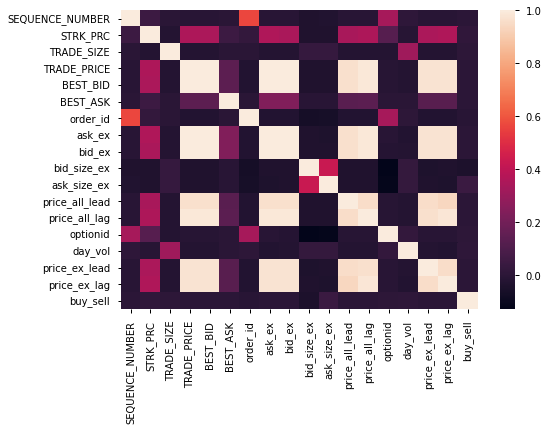

In [ ]:
corr = data.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

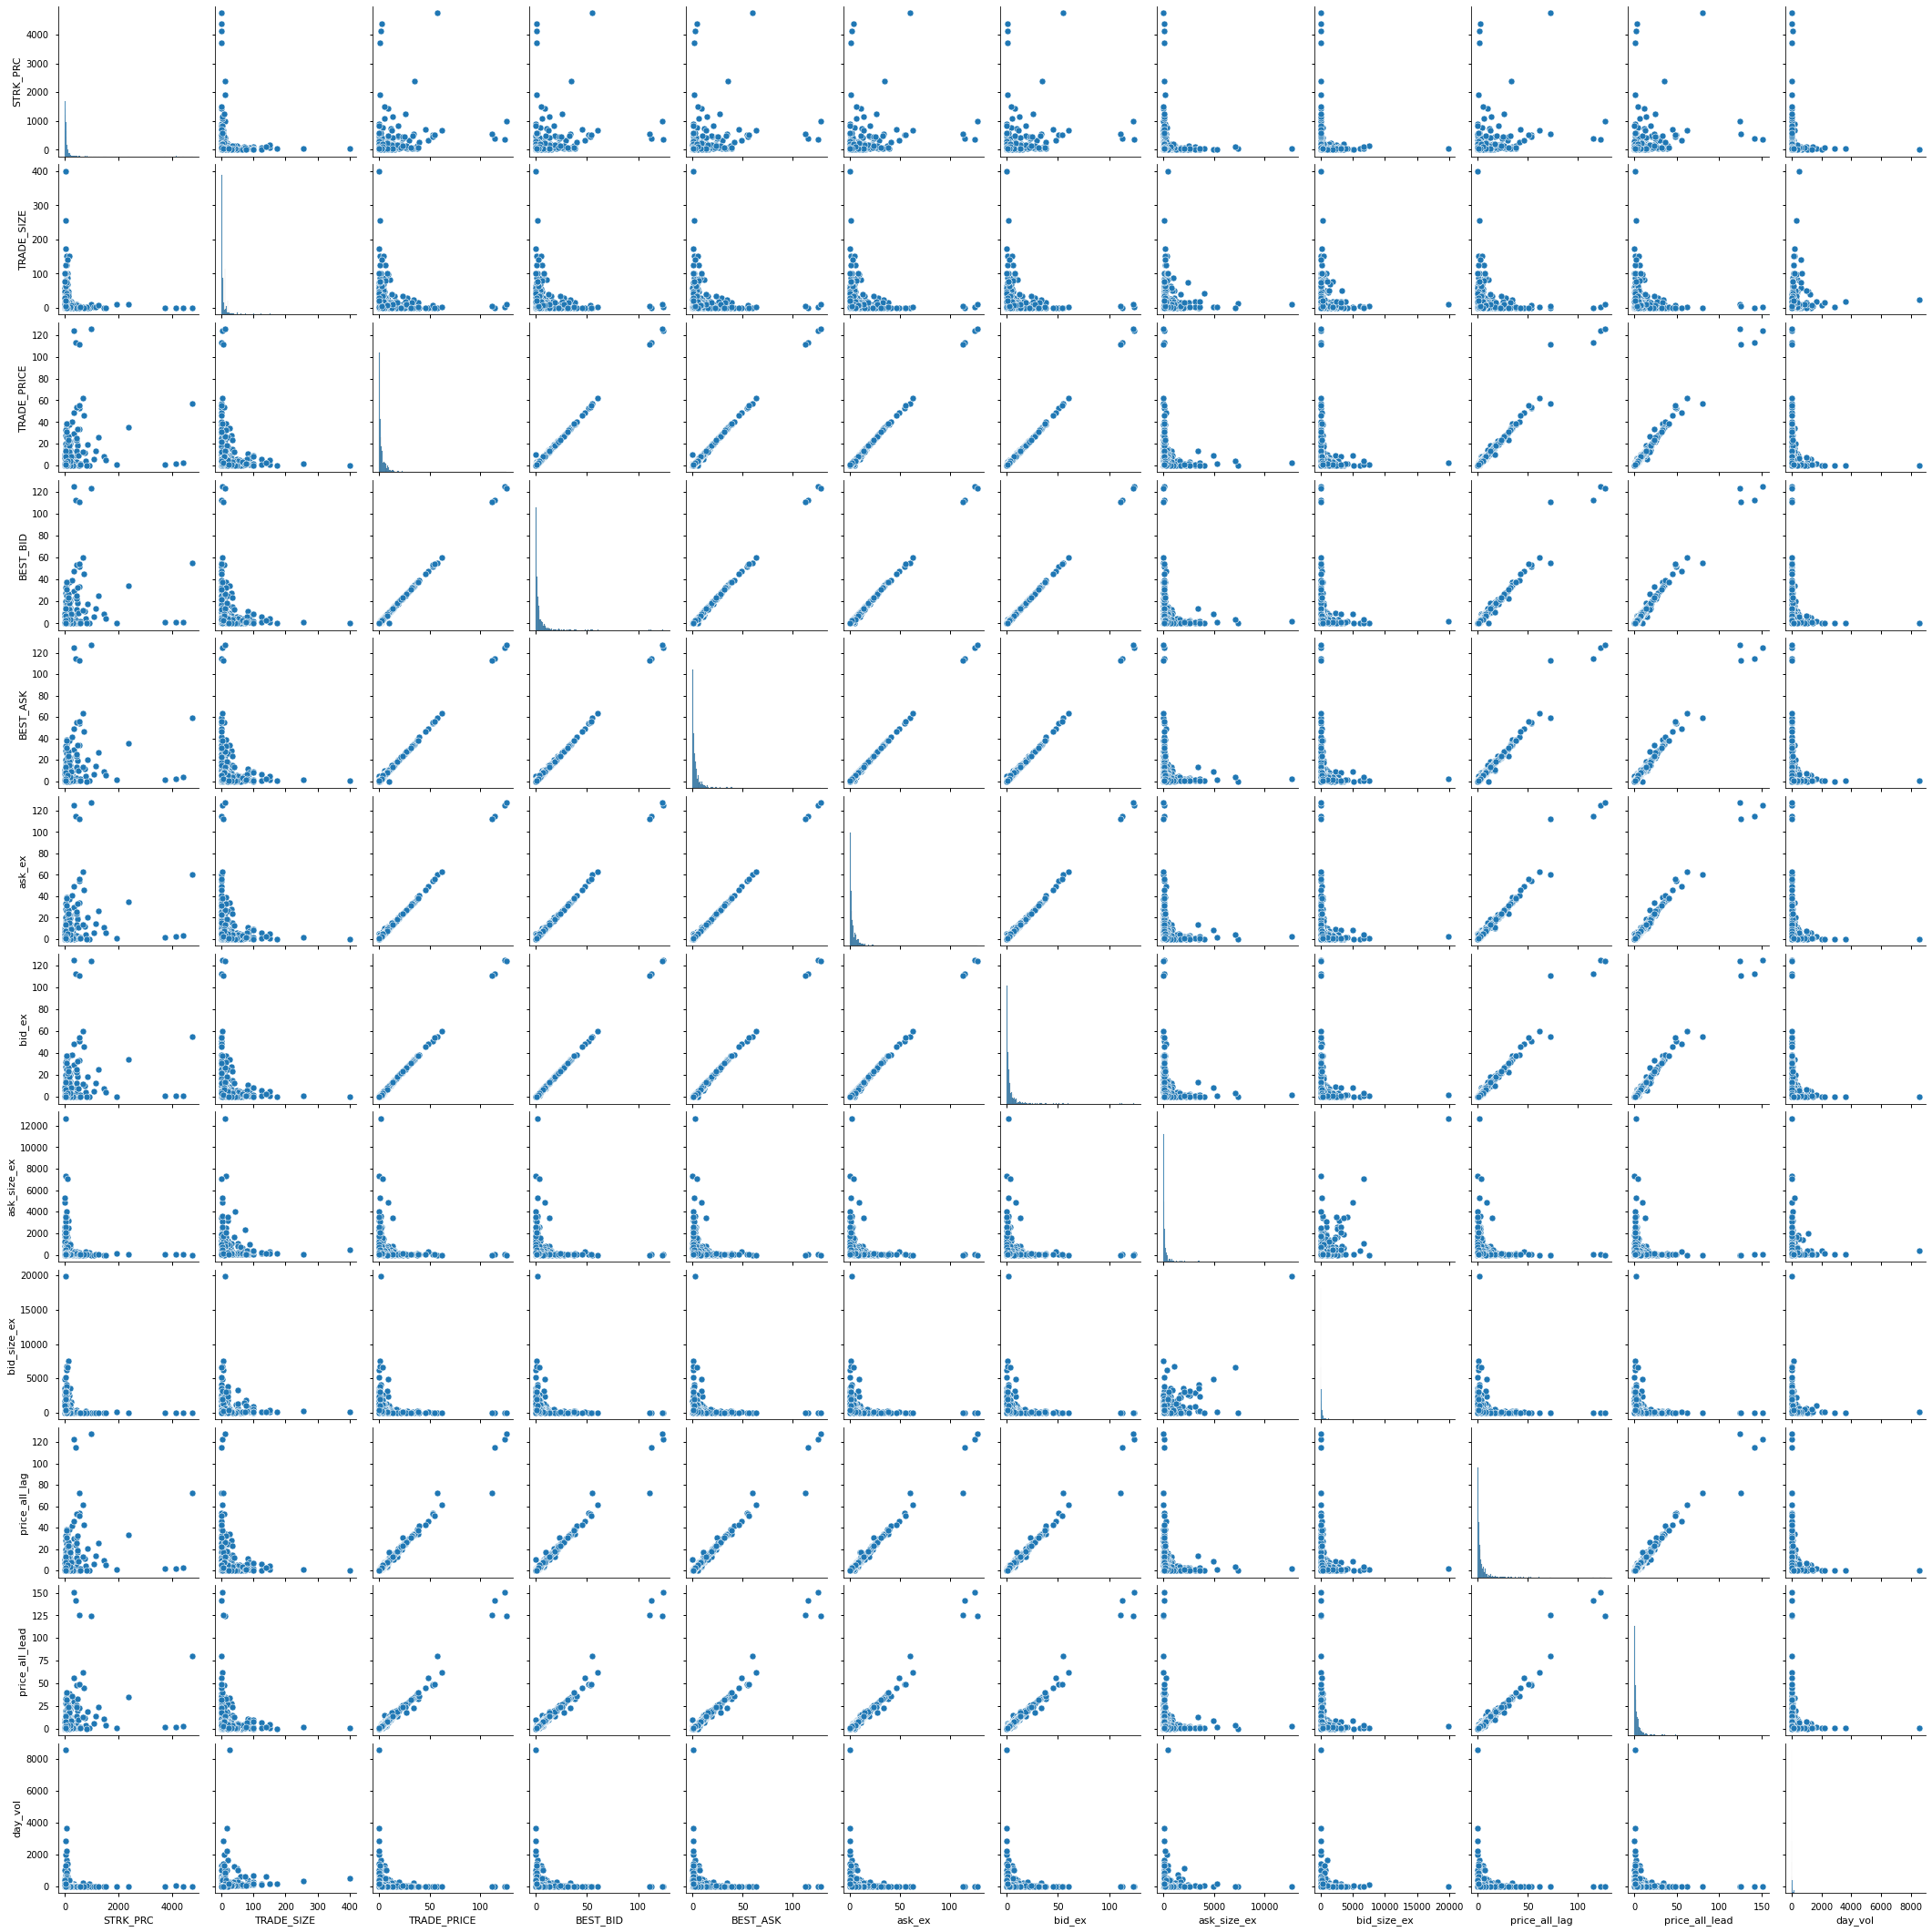

In [ ]:
sample = data.sample(n=1000, random_state=seed)
sns.pairplot(sample, vars=["STRK_PRC","TRADE_SIZE", "TRADE_PRICE", "BEST_BID", "BEST_ASK", "ask_ex", "bid_ex", "ask_size_ex", "bid_size_ex", "price_all_lag", "price_all_lead", "day_vol"])

In [ ]:
# TODO: add collinearity plots

## Preparation 🥗

### Positional Encoding

In [ ]:
# apply positional encoding to dates
data["date_month_sin"] = np.sin(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)
data["date_month_cos"] = np.cos(2 * np.pi * data["QUOTE_DATETIME"].dt.year / 12)

# time (daily)
seconds_in_day = 24*60*60
seconds = (data["QUOTE_DATETIME"] - data["QUOTE_DATETIME"].dt.normalize()).dt.total_seconds()

data["date_time_sin"] = np.sin(2*  np.pi* seconds / seconds_in_day)
data["date_time_cos"] = np.cos(2 * np.pi* seconds / seconds_in_day)

# year min-max scaled
data["date_year_min"] = (data["QUOTE_DATETIME"].dt.year - 2005) / (2017 - 2005)

# time to maturity
data["ttm"] = (
    data["EXPIRATION"].dt.to_period("M")
    - data["QUOTE_DATETIME"].dt.to_period("M")
).apply(lambda x: x.n)

# day and year
data["day"] = data["QUOTE_DATETIME"].dt.day
data["year"] = data["QUOTE_DATETIME"].dt.year
data["date"] = data["QUOTE_DATETIME"].dt.date

### Dates

In [ ]:
bins_tradesize = [0, 1, 3, 5, 11, np.inf]
trade_size_labels = ["(0,1]", "(1,3]", "(3,5]", "(5,11]", ">11"]
data["TRADE_SIZE_binned"] = pd.cut(
    data["TRADE_SIZE"], bins_tradesize, labels=trade_size_labels
)

bins_years = [2005, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
year_labels = [
    "2005-2007",
    "2008-2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
]
data["year_binned"] = pd.cut(data["year"], bins_years, labels=year_labels)

bins_ttm = [-1, 1, 2, 3, 6, 12, np.inf]
ttm_labels = [
    "ttm <= 1 month",
    "ttm (1-2] month",
    "ttm (2-3] month",
    "ttm (3-6] month",
    "ttm (6-12] month",
    "ttm > 12 month",
]
data["ttm_binned"] = pd.cut(data["ttm"], bins_ttm, labels=ttm_labels)

### Additional Features

In [ ]:
# Degree how much trade size is filled
data["rel_bid_size_ex"] = data["TRADE_SIZE"] / data["bid_size_ex"]
data["rel_ask_size_ex"] = data["TRADE_SIZE"] / data["ask_size_ex"]

# spread in $ between ask and bid
data['spread_ex'] = data['ask_ex'] - data['bid_ex']

# Calculate change similar to tick rule
data["chg_lead_ex"] = data["TRADE_PRICE"] - data["price_ex_lead"]

# Calculate change similar to reverse tick rule
data["chg_lag_ex"] = data["TRADE_PRICE"]- data["price_ex_lag"]

# Midspread
mid = 0.5 * (data["ask_ex"] + data["bid_ex"])

# Absolute distance from mid
data["abs_mid_ex"] = data["TRADE_PRICE"] - mid

## Trades over Time ⌚

In [ ]:
# TODO: Add recession data to time plots

In [ ]:
trades_per_day = data[["TRADE_PRICE"]].groupby(data["date"]).count()

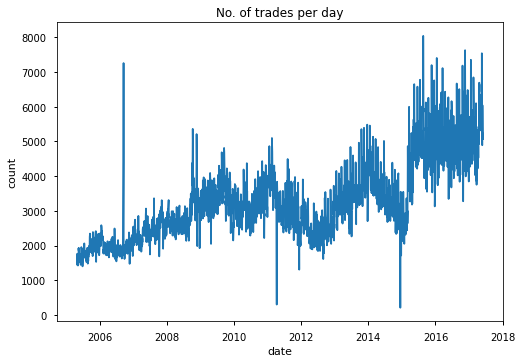

In [ ]:
ax = sns.lineplot(data=trades_per_day,x="date", y="TRADE_PRICE")
ax.yaxis.label.set_text("count")
ax.title.set_text("No. of trades per day")

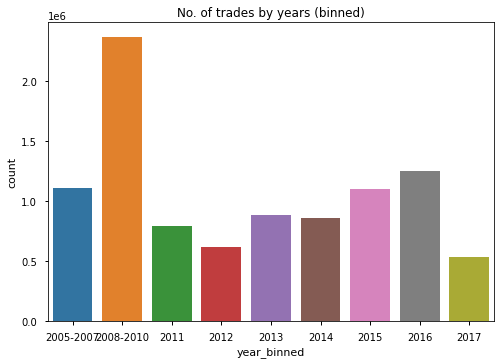

In [ ]:
ax = sns.countplot(data=data, x = "year_binned")
ax.title.set_text("No. of trades by years (binned)")

# Buy Sell 👛

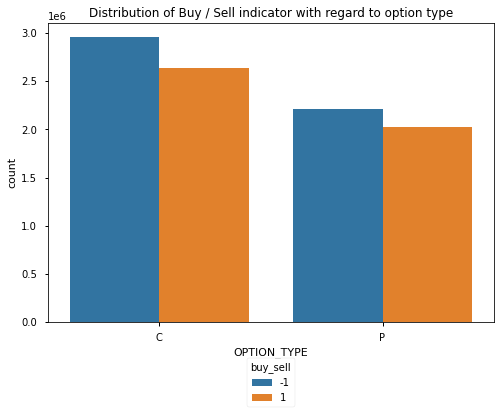

In [ ]:
ax = sns.countplot(data=data,x="OPTION_TYPE", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to option type")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))

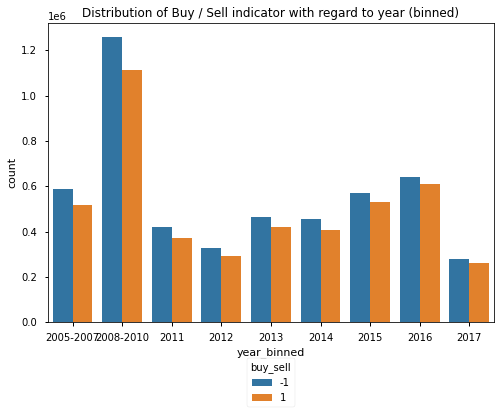

In [ ]:
ax = sns.countplot(data=data,x="year_binned", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to year (binned)")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))

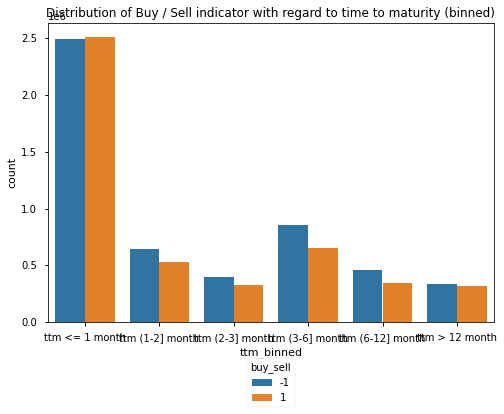

In [ ]:
ax = sns.countplot(data=data,x="ttm_binned", hue="buy_sell")
ax.title.set_text("Distribution of Buy / Sell indicator with regard to time to maturity (binned)")
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))

In [ ]:
trades_over_time = data[["buy_sell"]].value_counts()
trades_over_time = trades_over_time / trades_over_time.sum()

trades_over_time

buy_sell
-1          0.525473
 1          0.474527
dtype: float64

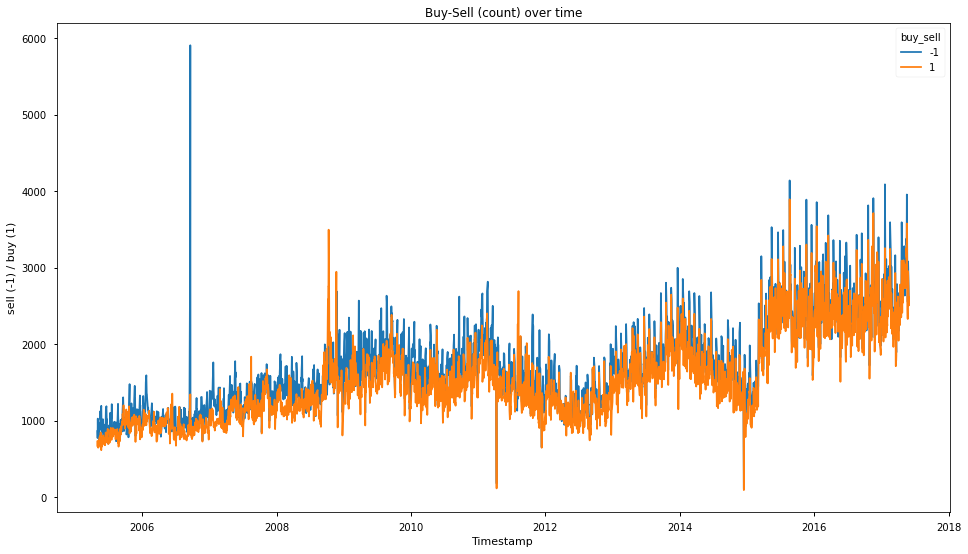

In [ ]:
trades_over_time = data.groupby(data['date'])["buy_sell"].value_counts().unstack(fill_value=0)
ax = trades_over_time.plot(kind="line", figsize=ratio, title="Buy-Sell (count) over time", xlabel="Timestamp", ylabel="sell (-1) / buy (1)")

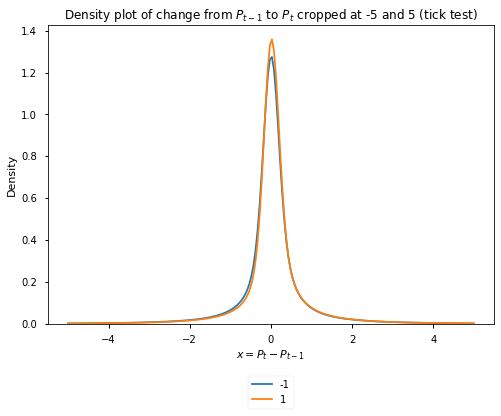

In [ ]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="chg_lead_ex", clip=[-5, 5], label=str(i), cumulative=False, common_grid=True)

ax.title.set_text("Density plot of change from $P_{t-1}$ to $P_{t}$ cropped at -5 and 5 (tick test)")
ax.xaxis.label.set_text("$x = P_{t} - P_{t-1}$")
ax.legend()
sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
plt.show()

In [ ]:
# TODO: Make subplot with distributions for other years. Esspecially first years.

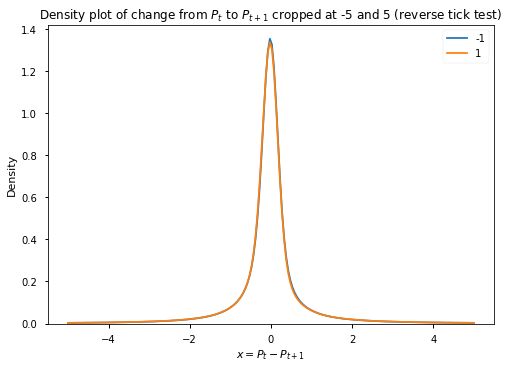

In [ ]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="chg_lag_ex", clip=[-5, 5], label=str(i), cumulative=False, common_grid=True)

ax.title.set_text("Density plot of change from $P_{t}$ to $P_{t+1}$ cropped at -5 and 5 (reverse tick test)")
ax.xaxis.label.set_text("$x = P_{t} - P_{t+1}$")
ax.legend()
#sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
plt.show()

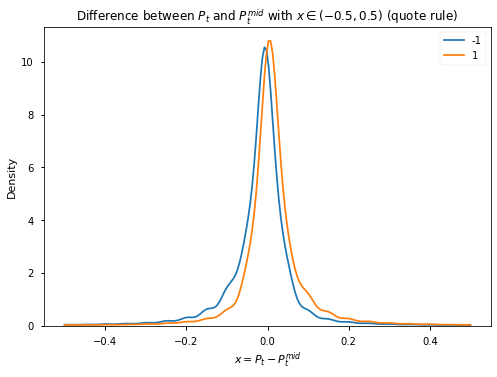

In [ ]:
fig, ax = plt.subplots()

for i in [-1,1]:
  sns.kdeplot(data=data[data["buy_sell"]==i], x="abs_mid_ex",clip=[-0.5, 0.5], label=str(i), cumulative=False)

ax.title.set_text("Difference between $P_{t}$ and $P_{t}^{mid}$ with $x \in(-0.5, 0.5)$ (quote rule)")
ax.xaxis.label.set_text("$x = P_{t} - P_{t}^{mid}$")
ax.legend()
#sns.move_legend(ax, "lower center", bbox_to_anchor=(0.5, -0.3))
plt.show()

# $n$ Most Frequent Symbols, Indices, and Special Codes 🔢

In [26]:
alphanumeric_symbols = data[~data['UNDERLYING_SYMBOL'].str.isalpha()]
alphanumeric_symbols.drop_duplicates(inplace=True)
print(alphanumeric_symbols.values)

[['^NDX']
 ['^MSH']
 ['NWS.A']
 ['^RUI']
 ['^RUT']
 ['VIA.B']
 ['^IVX']
 ['GRP.U']
 ['^TIN']
 ['CBS.A']
 ['^MID']
 ['^MNX']
 ['^SML']
 ['^RMN']
 ['RDS.A']
 ['^RCH']
 ['RGA.A']
 ['PBR.A']
 ['BRK.B']
 ['^YUK']
 ['^CDD']
 ['^EUI']
 ['^GBP']
 ['^EUU']
 ['^PZO']
 ['^MVR']
 ['^SKA']
 ['^AUX']
 ['^POW']
 ['^BPX']
 ['MUAE.E']
 ['^SFC']
 ['DENT.I']
 ['^BYT']
 ['HEY.NV']
 ['^JLO']
 ['^PMP']
 ['HWB.TC']
 ['^UKX']
 ['US.ESC']
 ['^HVY']
 ['^MFX']
 ['^BKX']
 ['^OOG']
 ['^FUM']
 ['GII.A']
 ['^AUM']
 ['^RND']
 ['^DMA']
 ['^SIN']
 ['^NDO']
 ['MUAB.S']
 ['^HHO']
 ['^BZJ']
 ['REX.M']
 ['HCP.PR']
 ['^HSX']
 ['^JKI.I']
 ['^IXZ']
 ['^NZD']
 ['^BRB']
 ['VALE.P']
 ['RDS.B']
 ['UAL1']
 ['PPL.PR']
 ['^WMX']
 ['U.PR.O']
 ['JN.PR']
 ['^DJP']
 ['KFN.PR']
 ['GOOG7']
 ['GLD7']
 ['^DJIID']
 ['^DJIGE']
 ['^DJIGS']
 ['^DJGEC']
 ['^DJIUK']
 ['^DJGTE']
 ['^KRDOW']
 ['A1HCR']
 ['BF.B']
 ['FBF.PR']
 ['HCN.PR']
 ['W2FIN']
 ['HUSI.P']
 ['MER.PR']
 ['HPQ1']
 ['URA1']
 ['NYLD.A']
 ['BAC.PR']
 ['UA.C']
 ['LGF.A']
 ['LGF.B']]


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [27]:
overlong_symbols = data[data['UNDERLYING_SYMBOL'].str.len()>=5]
overlong_symbols.drop_duplicates(inplace=True)
print(overlong_symbols.values)

[['CMCSA']
 ['ERICY']
 ['RSHCQ']
 ['OIHYY']
 ['DNDNQ']
 ['CMCSK']
 ['CHINA']
 ['LGNDE']
 ['CREAF']
 ['ESINQ']
 ['BTUUQ']
 ['COCOQ']
 ['NWS.A']
 ['UPLMQ']
 ['VISGE']
 ['ADCTD']
 ['VLCCF']
 ['BRCDE']
 ['IACID']
 ['LBTYA']
 ['MERQE']
 ['VIA.B']
 ['WTSLQ']
 ['SUNEQ']
 ['PWAVQ']
 ['SHPGY']
 ['GRP.U']
 ['NAVRE']
 ['TASRE']
 ['VISGD']
 ['CWTRQ']
 ['CBS.A']
 ['WTSLA']
 ['SOGCQ']
 ['ANRZQ']
 ['STPFQ']
 ['NTLID']
 ['NIHDQ']
 ['LCAPA']
 ['CIEND']
 ['DPTRQ']
 ['JDSUD']
 ['OSGIQ']
 ['MCDTA']
 ['JRCCQ']
 ['GMXRQ']
 ['LINTA']
 ['CEDCQ']
 ['GDPMQ']
 ['PALDF']
 ['DYNIQ']
 ['XINGF']
 ['ATPAQ']
 ['OUBSF']
 ['FBNIQ']
 ['EXMCQ']
 ['RDS.A']
 ['BKUNA']
 ['GULTU']
 ['WRESQ']
 ['ZQKSQ']
 ['PBCTD']
 ['PSUNQ']
 ['SVNTQ']
 ['HEROQ']
 ['GDRZF']
 ['CSUNY']
 ['IGATY']
 ['BRCDD']
 ['NSANY']
 ['IDCCD']
 ['TTCMY']
 ['CACHQ']
 ['LINEQ']
 ['SIEGY']
 ['ASMLD']
 ['LDKYQ']
 ['GNKOQ']
 ['JAVAD']
 ['LMDIA']
 ['TOPSD']
 ['SMSMY']
 ['DISCA']
 ['MVSND']
 ['XIDEQ']
 ['SDOCQ']
 ['ATVID']
 ['IACIV']
 ['SFYWQ']
 ['RGA.A']
 ['CDSDD']

,Symbol,Count
0,SPY,226704
1,AAPL,119043
2,IWM,106824
3,GLD,84215
4,^NDX,79038
5,GOOG,77554
6,AMZN,74044
7,DIA,72976
8,TLT,64314
9,PCLN,63221


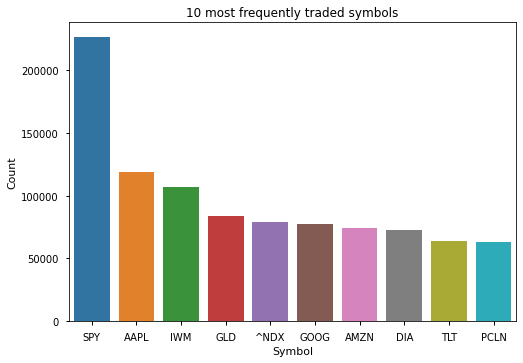

In [ ]:
most_frequent_symbols = data["UNDERLYING_SYMBOL"].value_counts().head(N).reset_index(name="Count")
most_frequent_symbols.rename(columns={'index':'Symbol'}, inplace=True)

ax = sns.barplot(data=most_frequent_symbols, x="Symbol", y="Count")
ax.title.set_text(f"{N} most frequently traded symbols")
most_frequent_symbols

In [ ]:
list_freq_symbols = most_frequent_symbols.Symbol.tolist()

In [ ]:
frequent_symbols_over_time = data[data["UNDERLYING_SYMBOL"].isin(list_freq_symbols)]

In [ ]:
frequent_symbols_trades_per_day = frequent_symbols_over_time.groupby([frequent_symbols_over_time.QUOTE_DATETIME.dt.to_period('m'), "UNDERLYING_SYMBOL"])["TRADE_SIZE"].count().reset_index().rename(columns={"TRADE_SIZE": "count", "QUOTE_DATETIME": "date", "UNDERLYING_SYMBOL": "Symbol"})


In [ ]:
frequent_symbols_trades_per_day.head()

,date,Symbol,count
0,2005-05,AAPL,224
1,2005-05,AMZN,94
2,2005-05,GOOG,367
3,2005-05,IWM,334
4,2005-05,PCLN,51


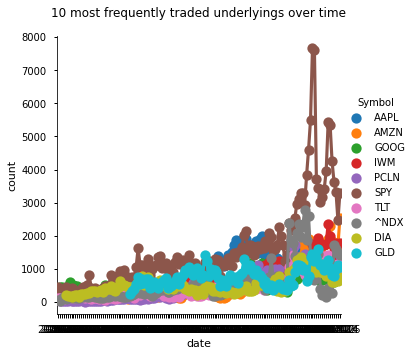

In [ ]:
plot = sns.catplot(data=frequent_symbols_trades_per_day, x="date", y="count", hue='Symbol', kind="point")
plot.figure.subplots_adjust(top=0.9)
plot.figure.suptitle(f"{N} most frequently traded underlyings over time");

In [ ]:
frequent_symbols_over_time

,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,date,TRADE_SIZE_binned,year_binned,ttm_binned,rel_bid_size_ex,rel_ask_size_ex,spread_ex,chg_lead_ex,chg_lag_ex,abs_mid_ex
33645515,AAPL,2014-09-17 13:24:38,1624573500,AAPL,2015-01-17,128.570007,C,5,0.360000,0.340000,...,2014-09-17,"(3,5]",2014,ttm (3-6] month,0.113636,1.000000,0.030000,-0.010000,0.01,0.015
5285911,AMZN,2007-06-04 15:19:47,38300704,ZQN,2007-07-21,80.000000,P,10,10.300000,10.100000,...,2007-06-04,"(5,11]",2005-2007,ttm <= 1 month,0.068966,0.009804,0.299999,1.000000,-1.20,0.050
18345553,DIA,2010-11-09 15:56:19,104869698,DIA,2010-12-31,113.000000,C,1,2.650000,2.610000,...,2010-11-09,"(0,1]",2008-2010,ttm <= 1 month,0.024390,0.012048,0.040000,0.470000,-0.35,0.020
37830620,DIA,2015-08-10 10:27:28,10602712,DIA,2015-11-20,174.000000,P,12,5.040000,4.950000,...,2015-08-10,>11,2015,ttm (2-3] month,0.016925,0.024845,0.150000,-0.550000,0.39,0.015
25346446,TLT,2012-10-16 15:53:43,42017150,TLT,2013-03-16,128.000000,P,2,9.840000,9.800000,...,2012-10-16,"(1,3]",2012,ttm (3-6] month,1.000000,0.005650,0.099999,0.670000,0.53,-0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38323222,^NDX,2015-09-04 11:49:08,232796796,NDX,2015-10-09,4400.000000,C,3,44.869999,43.400002,...,2015-09-04,"(1,3]",2015,ttm <= 1 month,1.500000,0.107143,6.399998,-0.610001,-2.52,1.270
26547032,^NDX,2013-02-21 14:07:29,145831198,NDX,2013-04-20,2325.000000,P,6,5.400000,5.400000,...,2013-02-21,"(5,11]",2013,ttm (1-2] month,1.000000,0.222222,0.100000,0.500000,2.78,-0.050
43378944,AAPL,2016-07-01 12:40:33,34198944,AAPL,2016-09-16,90.000000,C,1,7.590000,7.550000,...,2016-07-01,"(0,1]",2016,ttm (1-2] month,0.001621,0.008475,0.100000,-0.010000,1.96,-0.010
1947793,SPY,2006-02-22 10:25:38,22578384,SPY,2006-06-17,120.000000,P,1,0.900000,0.800000,...,2006-02-22,"(0,1]",2005-2007,ttm (3-6] month,0.000052,0.000106,0.100000,0.050000,-0.05,0.050


In [ ]:
data["symbol_is_index"] = data['UNDERLYING_SYMBOL'].str.startswith("^")

,Symbol,Count
0,^NDX,79038
1,^RUT,44495
2,^MNX,4045
3,^MSH,1170
4,^RUI,1032
5,^CDD,1031
6,^EUU,772
7,^YUK,669
8,^EUI,413
9,^GBP,333


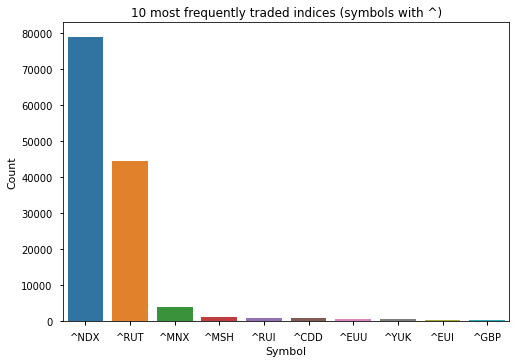

In [ ]:
most_frequent_indices = data[data["symbol_is_index"]]["UNDERLYING_SYMBOL"].value_counts().head(N).reset_index(name="Count")
most_frequent_indices.rename(columns={'index':'Symbol'}, inplace=True)

ax = sns.barplot(data=most_frequent_indices, x="Symbol", y="Count")
ax.title.set_text(f"{N} most frequently traded indices (symbols with ^)")
most_frequent_indices

In [ ]:
# 5th character in symbol
data["special_code"] = data['UNDERLYING_SYMBOL'].str[4]

In [ ]:
data["special_code"].value_counts(dropna=False)

NaN    9691862
Q        58610
L        35108
A        19131
B        13547
Y        12204
U         4349
F         3448
K         1723
D          364
E          284
R           36
P           23
.           18
S           17
X            8
V            6
N            4
O            2
7            2
M            1
I            1
W            1
Name: special_code, dtype: int64

**Observation:**
* `L`: Misc. (compare Google Shares)
* `B`: Class "B"
* `A`: Class "A"
* `K`: "Non-voting"
* `X`: "Mutual funds"
* `Y`: "ADRs"

Grauer et al. also include ETFs in `others`. Not sure how they are identified.

In [ ]:
# Security type similar to Grauer et. al p. 35
data['security_type'] = np.where(data["symbol_is_index"],"index option", np.where(data["special_code"].notnull(),"other", "stock option"))
data['security_type'] = data['security_type'].astype("category")

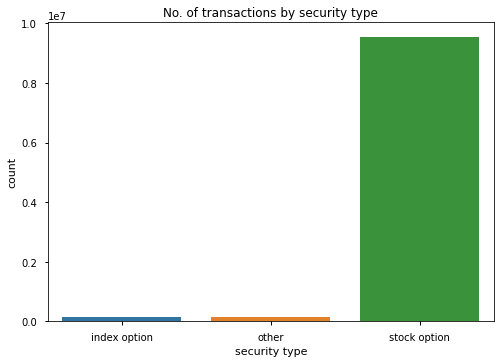

In [ ]:
ax = sns.countplot(data=data,x="security_type")
ax.title.set_text("No. of transactions by security type")
ax.xaxis.label.set_text("security type")

# Trade Prices and Sizes 🤝

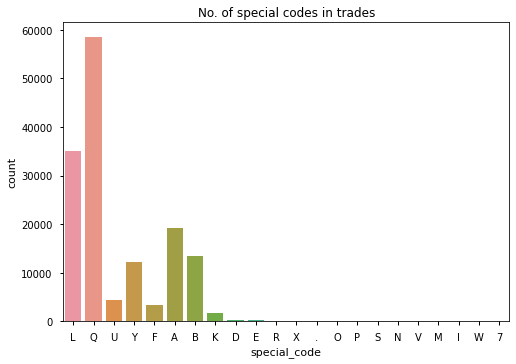

In [ ]:
ax = sns.countplot(data=data, x = "special_code")
ax.title.set_text("No. of special codes in trades")

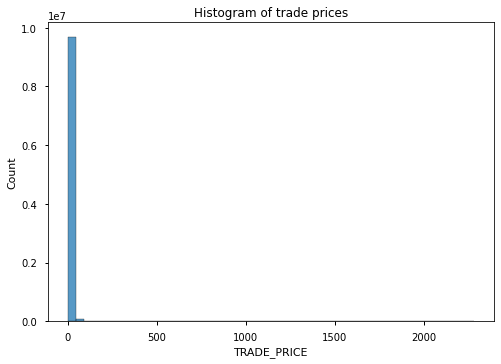

In [ ]:
ax = sns.histplot(data, x="TRADE_PRICE", bins=50)
ax.title.set_text("Histogram of trade prices")

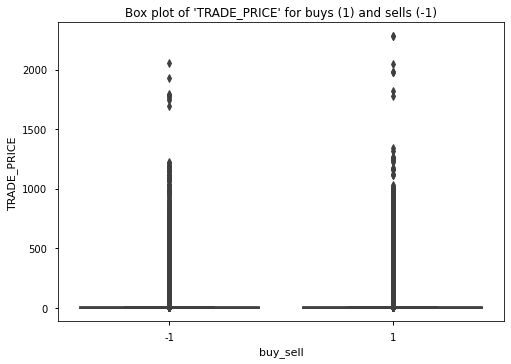

In [ ]:
ax = sns.boxplot(data = data, x="buy_sell", y = "TRADE_PRICE")
ax.title.set_text("Box plot of 'TRADE_PRICE' for buys (1) and sells (-1)")

**Observations:**
* Very few very large trade prices, many very small trade prices.
* Scaling can problematic, if outliers affect scaling much. Try $\log(\cdot)$ transform. Could improve results.

In [ ]:
data['log_trade_price'] = np.log(data["TRADE_PRICE"])
data['log_trade_price'].replace([np.inf, -np.inf], np.nan, inplace=True)

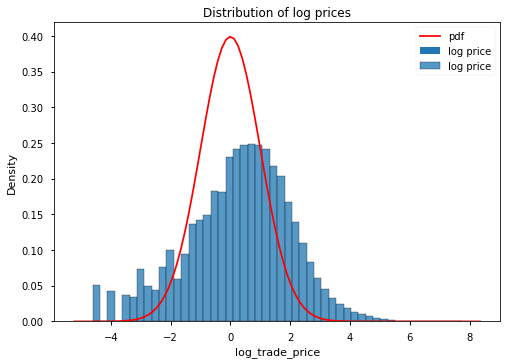

In [ ]:
fig, ax = plt.subplots()

sns.histplot(data, x="log_trade_price", bins=50, stat='density', label="log price")

# extract the limits for the x-axis and fit normal distributon
x0, x1 = ax.get_xlim()  
x_pdf = np.linspace(x0, x1, 100)
y_pdf = stats.norm.pdf(x_pdf)

pdf = pd.DataFrame({'x':x_pdf,'y':y_pdf})
sns.lineplot(data = pdf,x='x', y='y',label="pdf", color="r")


ax.title.set_text("Distribution of log prices")                                                   
ax.legend()

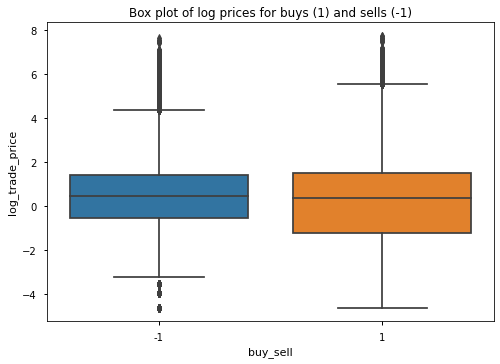

In [ ]:
ax = sns.boxplot(data=data, x="buy_sell", y="log_trade_price")
ax.title.set_text("Box plot of log prices for buys (1) and sells (-1)")

In [ ]:
data.nlargest(N, "TRADE_PRICE", keep='first').T

,33680345,33680332,38381463,32789549,32486891,32486875,32486793,39437552,38759890,38564014
UNDERLYING_SYMBOL,^NDX,^NDX,^NDX,^NDX,^NDX,^NDX,^NDX,^NDX,^NDX,^NDX
QUOTE_DATETIME,2014-09-19 12:21:28,2014-09-19 12:21:14,2015-09-10 09:42:03,2014-06-30 11:34:58,2014-06-06 10:14:12,2014-06-06 10:14:00,2014-06-06 10:12:54,2015-11-11 16:02:27,2015-10-05 09:56:59,2015-09-21 14:30:47
SEQUENCE_NUMBER,2364398603,2361135401,148984552,1727306702,980830903,977317501,952279501,31188174,17612557,118268223
ROOT,NDX,NDX,NDX,NDX,NDX,NDX,NDX,NDX,NDX,NDX
EXPIRATION,2014-12-20 00:00:00,2014-12-20 00:00:00,2016-06-17 00:00:00,2014-09-20 00:00:00,2014-09-20 00:00:00,2014-09-20 00:00:00,2014-09-20 00:00:00,2015-11-13 00:00:00,2016-12-16 00:00:00,2016-12-16 00:00:00
STRK_PRC,1800.0,1800.0,2200.0,1800.0,1800.0,1800.0,1800.0,2700.0,6100.0,6100.0
OPTION_TYPE,C,C,C,C,C,C,C,C,P,P
TRADE_SIZE,3,1,4,4,3,1,3,1,1,3
TRADE_PRICE,2281.97998,2281.48999,2057.25,2045.199951,1975.849976,1975.849976,1975.699951,1932.869995,1816.579956,1793.699951
BEST_BID,2278.100098,2278.100098,2052.100098,2044.099976,1973.5,1973.5,1973.5,1925.5,1808.0,1786.0


In [ ]:
data.nsmallest(N, "TRADE_PRICE", keep='first').T

,48104749,19780542,10715752,11185445,27164978,38450533,11568455,15659156,42921907,46721572
UNDERLYING_SYMBOL,XME,SLV,VLO,BKC,TBT,T,INTC,FAZ,XME,SPY
QUOTE_DATETIME,2017-04-04 11:04:45,2011-03-03 11:44:50,2009-01-02 12:09:42,2009-02-13 15:27:11,2013-04-17 11:08:08,2015-09-15 10:36:28,2009-03-19 15:34:08,2010-03-09 09:36:38,2016-06-06 12:30:06,2017-01-13 13:24:43
SEQUENCE_NUMBER,35527956,89224478,35098957,15428077,50718351,1153824948,18083073,3696840,153844348,89415734
ROOT,XME,SLV,VLO,BKC,TBT,T,NQ,FAY,XME,SPY
EXPIRATION,2017-04-21 00:00:00,2011-03-19 00:00:00,2009-01-17 00:00:00,2009-02-21 00:00:00,2013-04-20 00:00:00,2015-09-18 00:00:00,2009-03-21 00:00:00,2010-03-20 00:00:00,2016-06-17 00:00:00,2017-01-18 00:00:00
STRK_PRC,35.0,25.0,45.0,15.0,64.0,34.0,17.0,35.0,30.0,238.5
OPTION_TYPE,C,P,C,P,C,C,C,C,C,C
TRADE_SIZE,2,41,2,10,1,10,1,4,1,30
TRADE_PRICE,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
BEST_BID,0.0,0.01,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


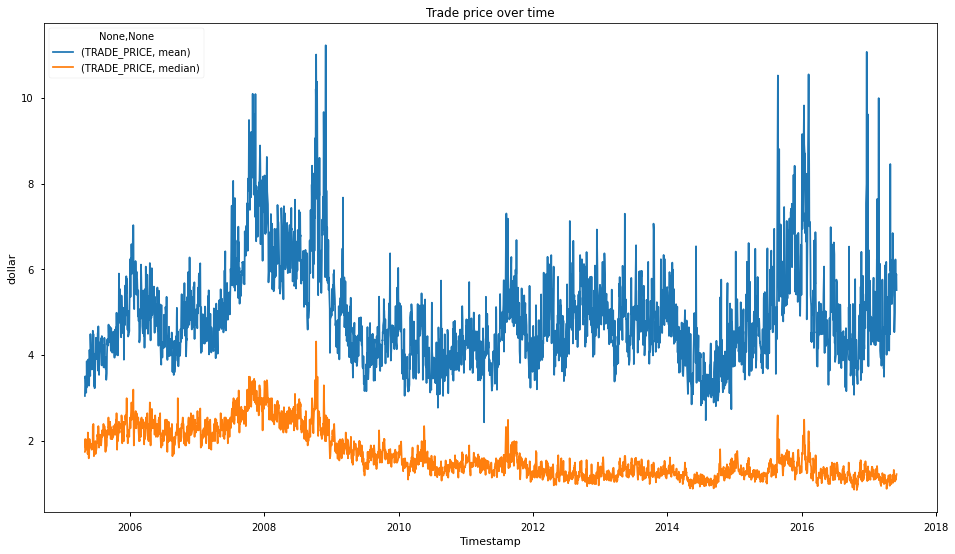

In [ ]:
trades_over_time = data[["TRADE_PRICE"]].groupby(data['date']).agg(['mean','median'])
trades_over_time.plot(kind="line", figsize=ratio, title="Trade price over time", xlabel="Timestamp", ylabel="dollar")

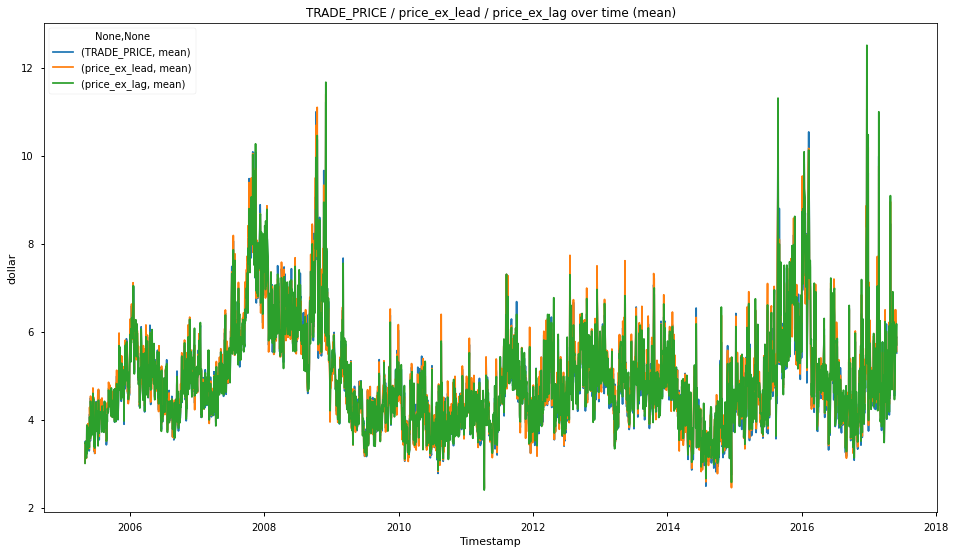

In [ ]:
lead_lag_trade_price = data[["TRADE_PRICE", "price_ex_lead", "price_ex_lag"]].groupby(data['date']).agg(['mean'])
lead_lag_trade_price.plot(kind="line", figsize=ratio, title="TRADE_PRICE / price_ex_lead / price_ex_lag over time (mean)", xlabel="Timestamp", ylabel="dollar")

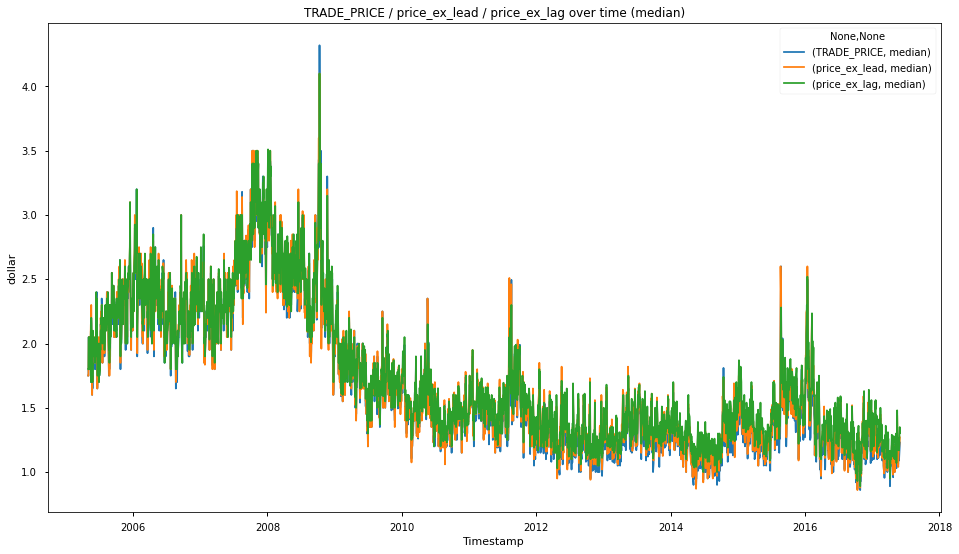

In [ ]:
lead_lag_trade_price = data[["TRADE_PRICE", "price_ex_lead", "price_ex_lag"]].groupby(data['date']).agg(['median'])
lead_lag_trade_price.plot(kind="line", figsize=ratio, title="TRADE_PRICE / price_ex_lead / price_ex_lag over time (median)", xlabel="Timestamp", ylabel="dollar")

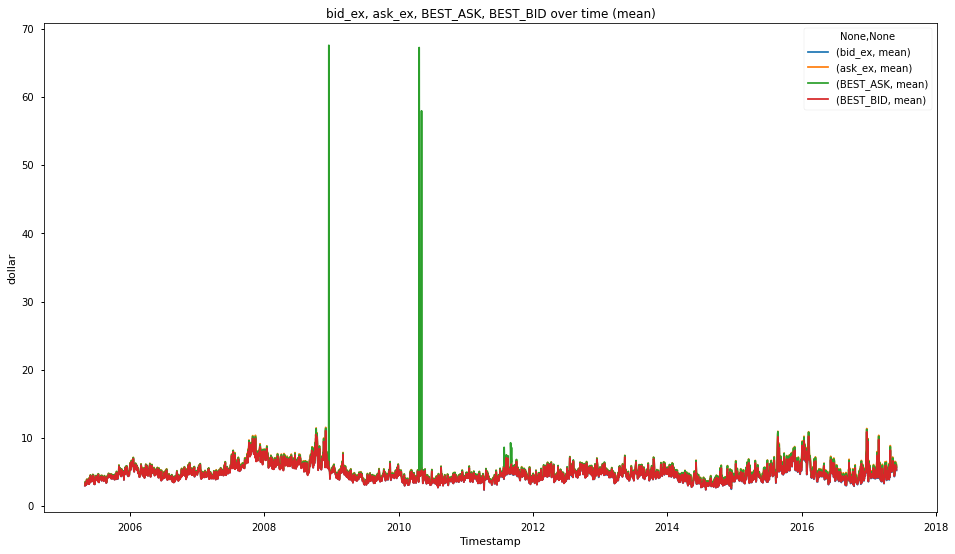

In [ ]:
lead_lag_trade_price = data[["bid_ex", "ask_ex", "BEST_ASK", "BEST_BID"]].groupby(data['date']).agg(['mean'])
lead_lag_trade_price.plot(kind="line", figsize=ratio, title="bid_ex, ask_ex, BEST_ASK, BEST_BID over time (mean)", xlabel="Timestamp", ylabel="dollar")

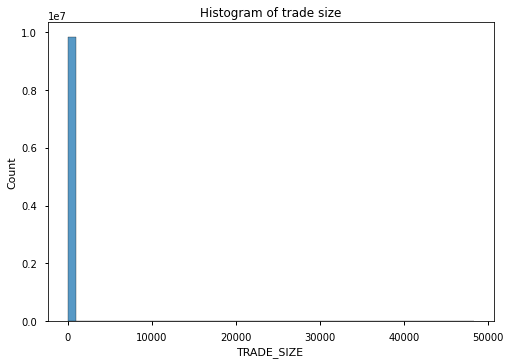

In [ ]:
# Think about outliers
ax = sns.histplot(data, x="TRADE_SIZE", bins=50)
ax.title.set_text("Histogram of trade size")

**Observation:**
* highly skewed with few outliers.
* Similar to the price, $\log(\cdot)$ transform helps a little bit.

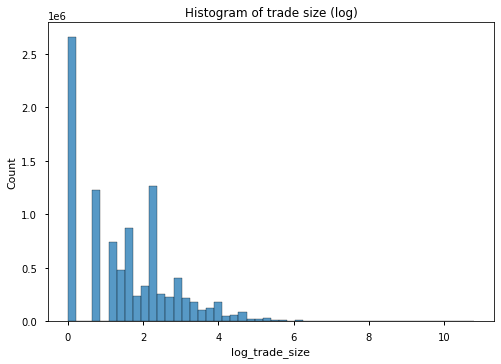

In [ ]:
data['log_trade_size'] = np.log(data["TRADE_SIZE"])
ax = sns.histplot(data, x="log_trade_size", bins=50)
ax.title.set_text("Histogram of trade size (log)")

In [ ]:
data.nlargest(N, "TRADE_SIZE", keep='first').T

,39949553,47165585,25263752,30910096,14000373,6860075,34933497,29533248,42918503,5732573
UNDERLYING_SYMBOL,SVU,USO,SPY,XLF,EWJ,DIA,USO,XLF,EEM,XLB
QUOTE_DATETIME,2015-12-11 15:22:27,2017-02-08 10:48:04,2012-10-05 14:09:56,2014-02-03 15:51:17,2009-10-07 13:01:39,2007-11-30 14:42:49,2015-01-23 15:50:44,2013-10-28 09:40:06,2016-06-06 11:23:32,2007-07-30 09:39:07
SEQUENCE_NUMBER,51029631,17703863,86403977,2819929000,65911082,74689815,66629137,149406301,150835276,3004135
ROOT,SVU,USO,SPY,XLF,EWJ,DAW,USO,XLF,EEM,XLB
EXPIRATION,2016-01-15 00:00:00,2017-05-19 00:00:00,2012-12-22 00:00:00,2014-02-22 00:00:00,2009-12-19 00:00:00,2008-03-22 00:00:00,2015-02-20 00:00:00,2014-01-18 00:00:00,2016-06-24 00:00:00,2007-09-22 00:00:00
STRK_PRC,5.0,10.5,123.0,18.0,11.0,132.0,16.5,19.0,35.0,36.0
OPTION_TYPE,C,P,P,P,C,P,P,C,C,P
TRADE_SIZE,48332,30000,30000,26724,25000,24818,23643,22502,22100,21000
TRADE_PRICE,1.7,0.41,0.35,0.02,0.05,5.24,0.86,1.91,0.21,0.58
BEST_BID,1.55,0.39,0.33,0.02,0.0,5.15,0.83,1.91,0.2,0.55


# Bid, Ask, and Spread 🛍️

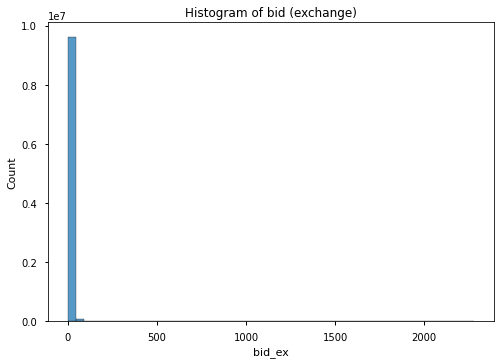

In [ ]:
ax = sns.histplot(data, x="bid_ex", bins=50)
ax.title.set_text("Histogram of bid (exchange)")

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


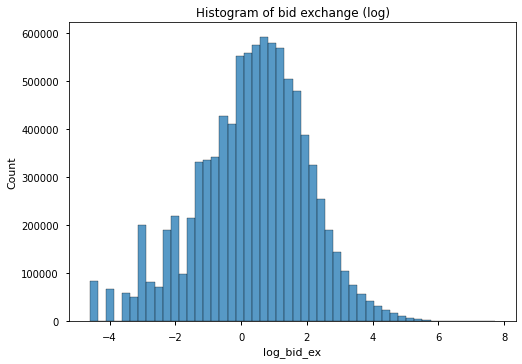

In [ ]:
data['log_bid_ex'] = np.log(data["bid_ex"])
ax = sns.histplot(data, x="log_bid_ex", bins=50)
ax.title.set_text("Histogram of bid exchange (log)")

In [ ]:
mean_spread = data["spread_ex"].groupby(data['date']).agg(['mean'])

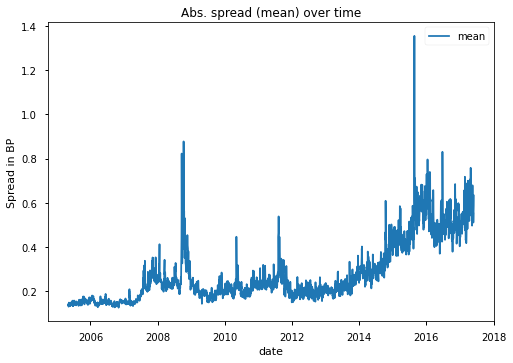

In [ ]:
ax = sns.lineplot(mean_spread)
ax.title.set_text("Abs. spread (mean) over time")
ax.yaxis.label.set_text("Spread in BP")

# Time to Maturity ⌚

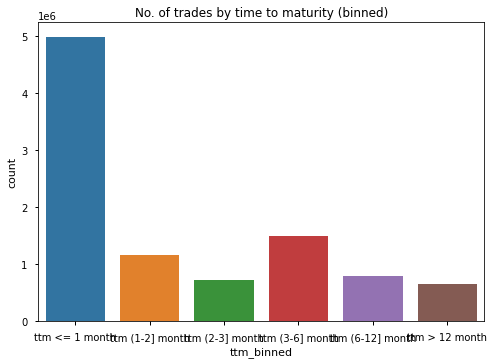

In [ ]:
ax = sns.countplot(data=data, x = "ttm_binned")
ax.title.set_text("No. of trades by time to maturity (binned)")

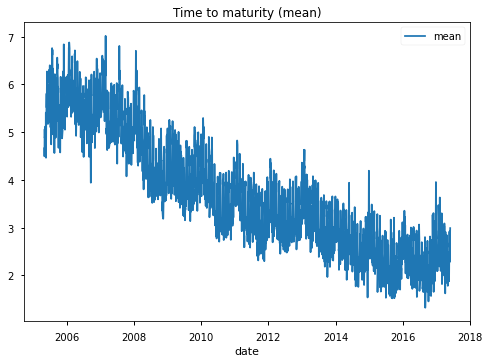

In [ ]:
mean_time_2_maturity = data["ttm"].groupby(data['date']).agg(['mean'])
ax = sns.lineplot(mean_time_2_maturity)
ax.title.set_text("Time to maturity (mean)")

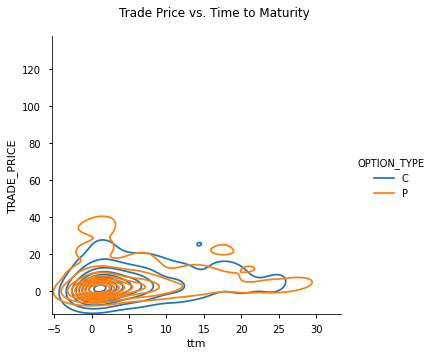

In [ ]:
sample = data.sample(n=1000, random_state=seed)

plot = sns.displot(data = sample, 
                x = "ttm", 
                y = "TRADE_PRICE", kind="kde", hue="OPTION_TYPE")
plot.figure.subplots_adjust(top=0.9)
plot.figure.suptitle("Trade Price vs. Time to Maturity");

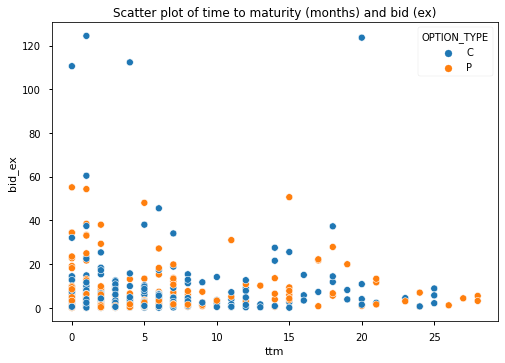

In [ ]:
ax = sns.scatterplot(data = sample, 
                x = "ttm", 
                y = "bid_ex",
                hue= "OPTION_TYPE")
ax.title.set_text("Scatter plot of time to maturity (months) and bid (ex)")

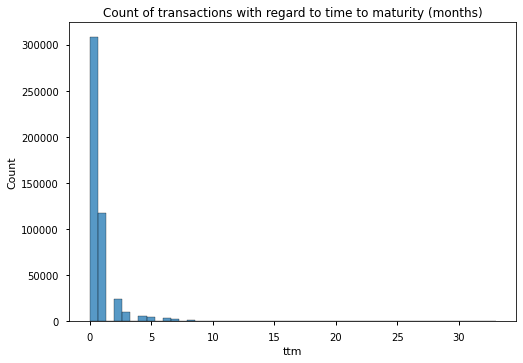

In [ ]:
ax = sns.histplot(data = data[data["bid_ex"]==0.0], 
                  x = "ttm", bins=50)
ax.title.set_text("Count of transactions with regard to time to maturity (months)")

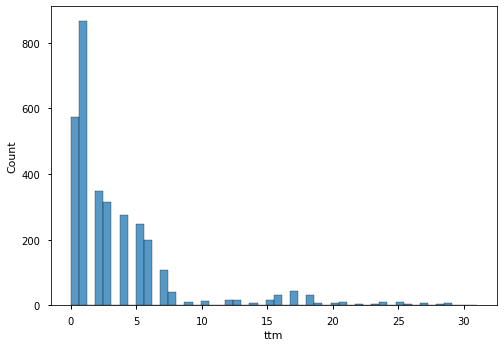

In [ ]:
# TODO: ask of zero plausible?
sns.histplot(data = data[data["ask_ex"]==0.0], 
                x = "ttm", bins=50)

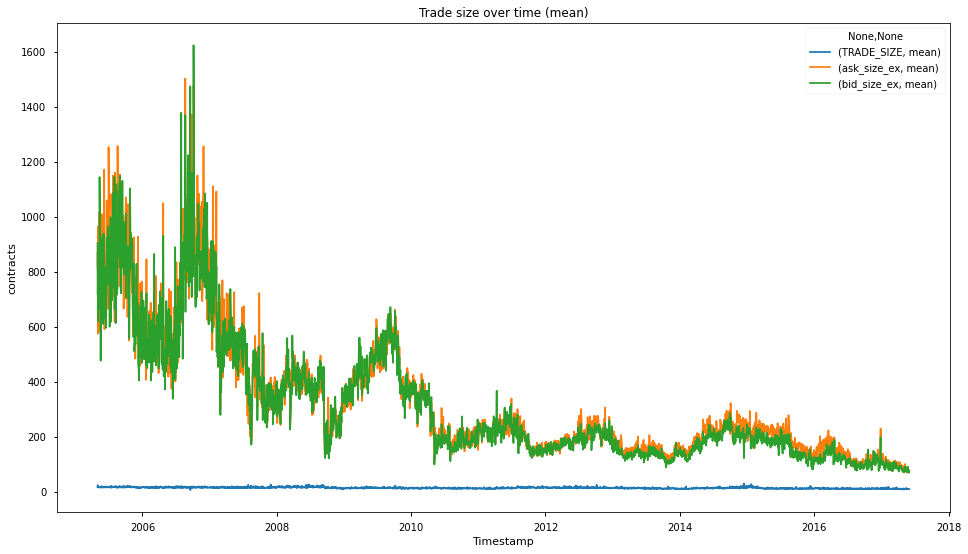

In [ ]:
trades_over_time = data[["TRADE_SIZE", "ask_size_ex", "bid_size_ex"]].groupby(data['date']).agg(['mean'])
trades_over_time.plot(kind="line", figsize=ratio, title="Trade size over time (mean)", xlabel="Timestamp", ylabel="contracts")

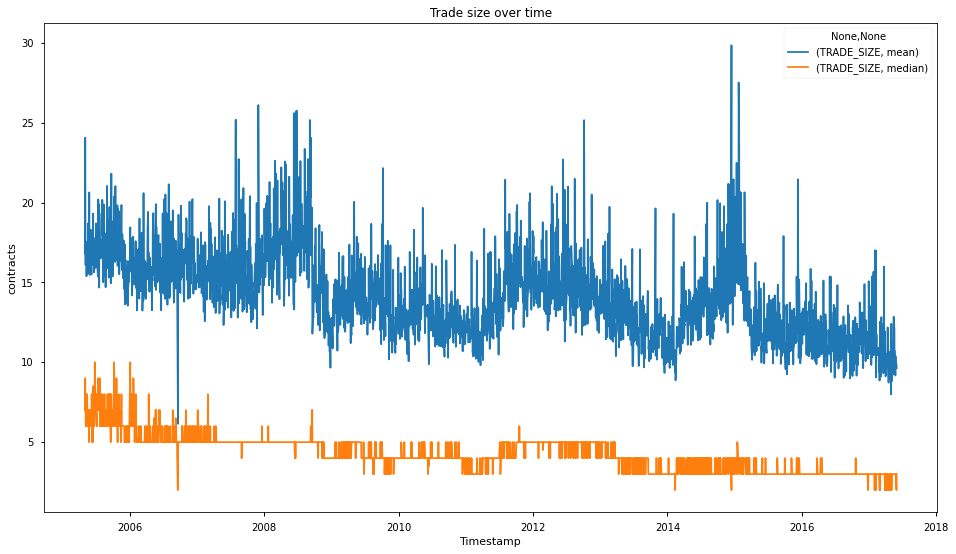

In [ ]:
trades_over_time = data[["TRADE_SIZE"]].groupby(data['date']).agg(['mean','median'])
trades_over_time.plot(kind="line", figsize=ratio, title="Trade size over time", xlabel="Timestamp", ylabel="contracts")

# Strike Price 💷

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8354644a50>]],
      dtype=object)

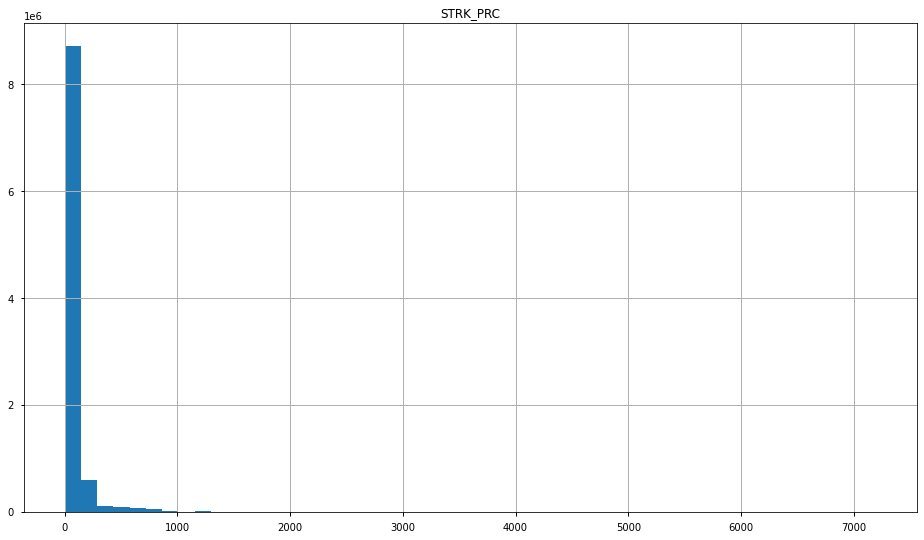

In [ ]:
data[["STRK_PRC"]].hist(figsize=ratio, bins=50)

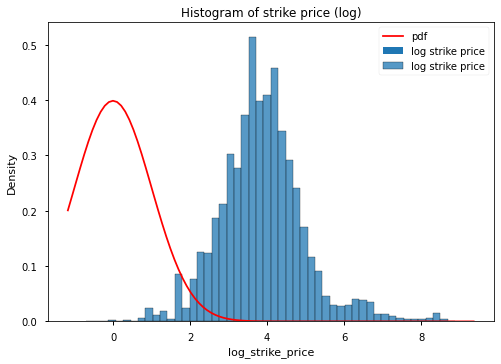

In [ ]:
fig, ax = plt.subplots()

data['log_strike_price'] = np.log(data["STRK_PRC"])

ax = sns.histplot(data, x= "log_strike_price", bins=50, stat='density', label="log strike price")
ax.title.set_text("Histogram of strike price (log)")

# extract the limits for the x-axis and fit normal distributon
x0, x1 = ax.get_xlim()  
x_pdf = np.linspace(x0, x1, 100)
y_pdf = stats.norm.pdf(x=x_pdf)

pdf = pd.DataFrame({'x':x_pdf,'y':y_pdf})
sns.lineplot(data = pdf,x='x', y='y',label="pdf", color="r")

# NaNs 🪲

In [ ]:
def visualize_nan():
    """
    Visualize NaN values in a heatmap to learn about patterns.
    """
    plt.subplots()
    sns.heatmap(data.head(50).isnull(), cbar=False)
    plt.xlabel("feature")
    plt.ylabel("row")
    plt.title("Missing values (colored in bright beige)")
    plt.show()

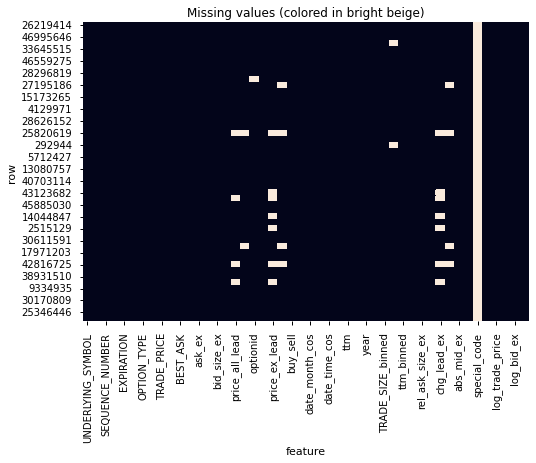

In [ ]:
visualize_nan()

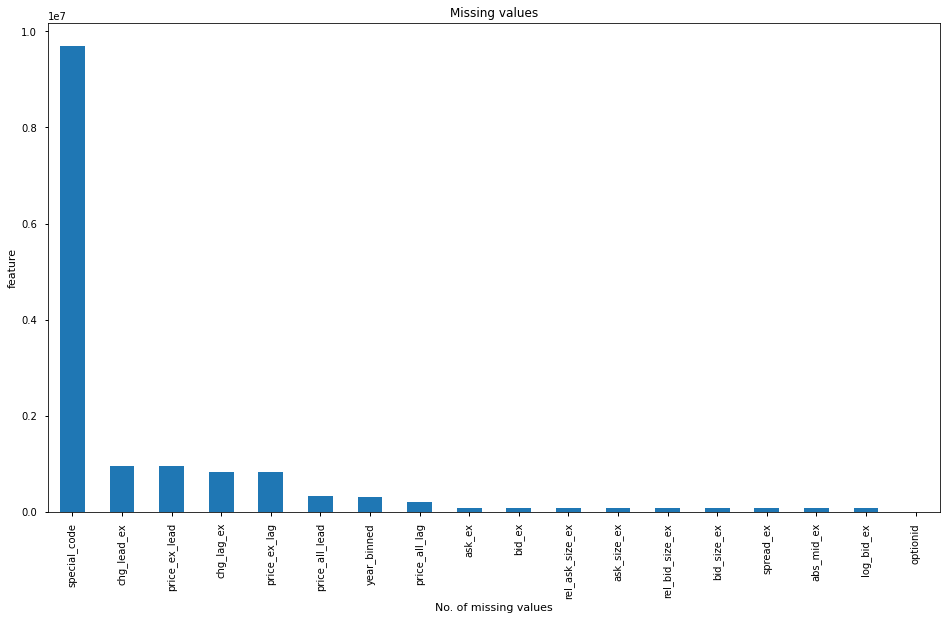

In [ ]:
isna_vals = data.isna().sum().sort_values(ascending=False)
isna_vals = isna_vals.loc[lambda x: x > 0]

ax = isna_vals.T.plot(kind="bar", figsize=ratio, legend=False, 
                      xlabel="No. of missing values", 
                      ylabel="feature", 
                      title="Missing values")

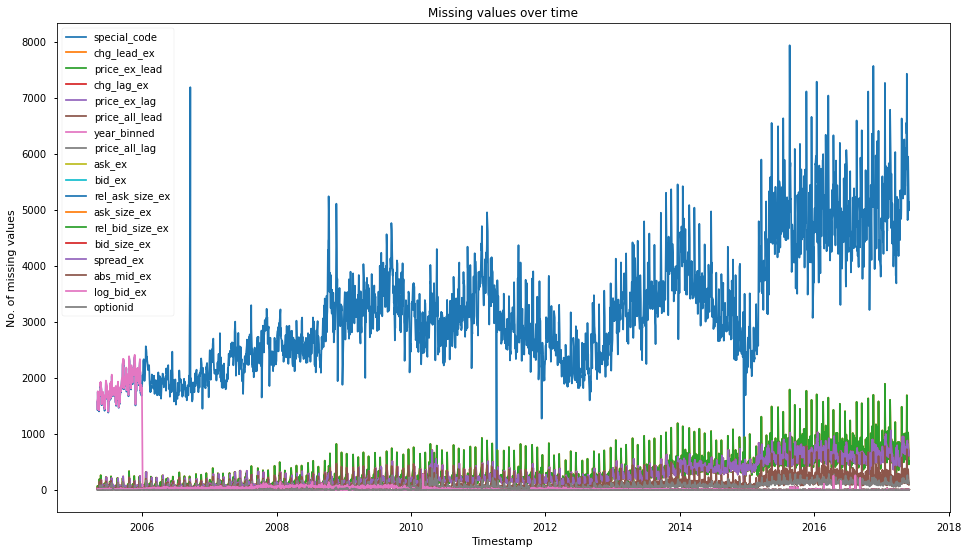

In [ ]:
isna_vals_over_time = data[isna_vals.index.tolist()].groupby(data['QUOTE_DATETIME'].dt.date).agg(lambda x: x.isnull().sum())
isna_vals_over_time.plot(kind="line", figsize=ratio, title="Missing values over time", xlabel="Timestamp", ylabel="No. of missing values")

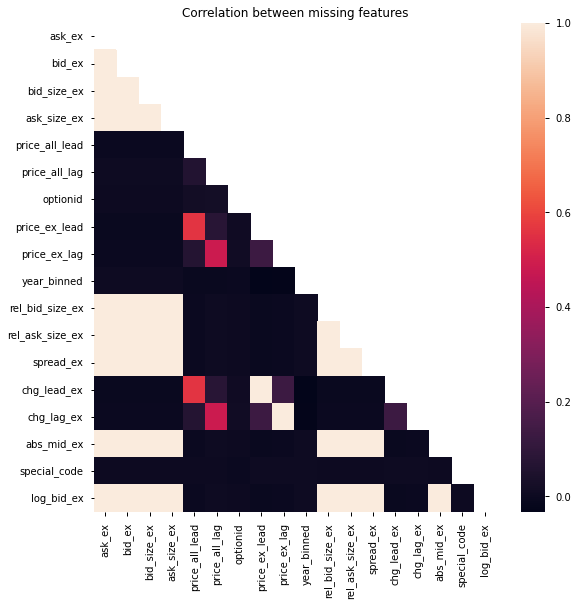

In [ ]:
# adapted from: https://github.com/ResidentMario/missingno/blob/master/missingno/missingno.py

isna_data = data.iloc[:, [i for i, n in enumerate(np.var(data.isnull(), axis='rows')) if n > 0]]

corr_mat = isna_data.isnull().corr()
mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(9,9)) 
ax = sns.heatmap(corr_mat, mask=mask, annot=False, annot_kws={'size':10}, ax=ax)
ax.title.set_text("Correlation between missing features")

In [ ]:
# TODO: Check if there is a pattern between the missing values